# TIM - Examen Pratique 2020-2021
## Lundi 18 Janvier 2021

In [1]:
# A compléter
# Importer ici les packages qui vous seront nécessaires pour cette partie de l'examen
import cv2
import numpy as np
from matplotlib import pyplot as plt

path_image = '../Base_images/'

# Partie Implémentation : Histogram Backprojection

Pour cet exercice, votre mission, si vous l'acceptez, sera d'implémenter l'algorithme "Histogram backprojection". Cet algorithme a été proposé par Michael J. Swain , Dana H. Ballard dans leur article "Indexing via color histograms" en 1990.

Cet algorithme est utilisé principalement pour de la segmentation d'image ou pour de la détection d'objets. A partir d'une image et d'une région d'intérêt (Region Of Interest ou ROI), l'histogram backprojection retourne une image de la même taille où chaque pixel correspond à la probabilité que ce pixel appartienne à la région d'intérêt. Cette image est créée grâce à l'analyse des histogrammes 2D de l'image d'entrée et de la ROI, converties en HSV.

La tâche qu'on va réaliser avec histogram backprojection est la segmentation d'images, à savoir la création d'une matrice de même taille que l'image d'entrée, où chaque pixel contient comme valeur la classe de l'objet (exemple en image ci-dessous). Cependant, avec notre algo, on va uniquement segmenter une zone d'intérêt, donc une seule classe d'objet.

<img src="../Base_images/Segmentation.png" style="width: 600px;"/>


## Partie 1 : Roses are red, Violets are blue...

---
1) Chargez l'image (rose.png) et la ROI (rose_roi.png) en RGB pour la démonstration et affichez-les.

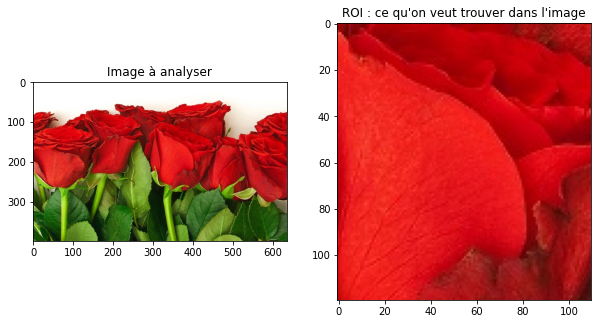

In [19]:
# A compléter
# Chargement et affichage en RGB de l'image à analyser et de la région d'intérêt
image = cv2.cvtColor(cv2.imread(path_image+'rose.png',1),cv2.COLOR_BGR2RGB)
roi = cv2.cvtColor(cv2.imread(path_image+'rose_roi.png',1),cv2.COLOR_BGR2RGB)

plt.subplots(2,1,figsize=(10,10))
plt.subplot(121)
plt.imshow(image)
plt.title("Image à analyser")
plt.subplot(122)
plt.imshow(roi)
plt.title("ROI : ce qu'on veut trouver dans l'image")
plt.show()

Vous l'avez compris : l'objectif sera de détecter les têtes de roses rouges. La ROI est une zone extraite de l'image (au centre).

---
2) Convertissez l'image et la ROI en HSV et affichez les résultats channel par channel (en niveau de gris)

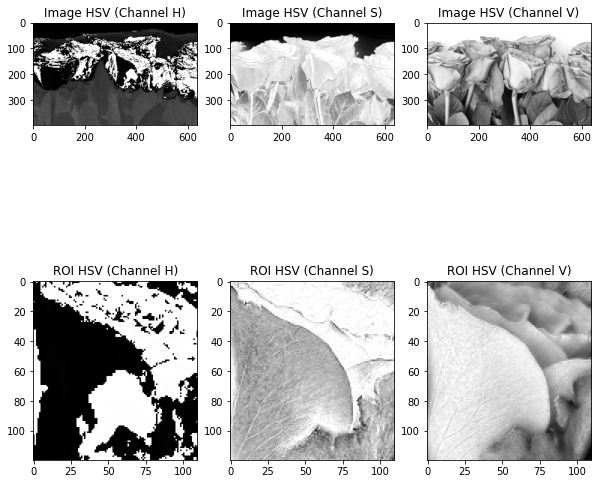

In [20]:
# A compléter
# Conversion HSV et affichage de l'image et de la ROI
hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
hsv_roi = cv2.cvtColor(roi,cv2.COLOR_RGB2HSV)

plt.subplots(2,3,figsize=(10,10))
plt.subplot(231)
plt.imshow(hsv_image[:,:,0],'gray')
plt.title("Image HSV (Channel H)")
plt.subplot(232)
plt.imshow(hsv_image[:,:,1],'gray')
plt.title("Image HSV (Channel S)")
plt.subplot(233)
plt.imshow(hsv_image[:,:,2],'gray')
plt.title("Image HSV (Channel V)")
plt.subplot(234)
plt.imshow(hsv_roi[:,:,0],'gray')
plt.title("ROI HSV (Channel H)")
plt.subplot(235)
plt.imshow(hsv_roi[:,:,1],'gray')
plt.title("ROI HSV (Channel S)")
plt.subplot(236)
plt.imshow(hsv_roi[:,:,2],'gray')
plt.title("ROI HSV (Channel V)")
plt.show()

---
3) Calculez maintenant les histogrammes 2D de l'image HSV et la ROI HSV, qui s'appeleront respectivement I et M. L' histogramme 2D d'une image est une matrice 2D avec en abscisse les valeurs possibles de l'image sur le channel H, et en ordonnée les valeurs possibles de l'image sur le channel S. Par exemple, un histogramme 2D aura aux coordonnées (x,y) le nombre de pixels de l'image correspondante ayant sur le channel H la valeur x ET sur le channel S la valeur y.

Vous pouvez soit coder la fonction à la main, soit utiliser une fonction qui permet de le calculer.

In [21]:
# A compléter
# Calcul des histogrammes 2D de l'image HSV et de la ROI HSV

# Version manuelle
def histogram2D(hsv):
    # Les valeurs possibles de H sont les entiers positifs entre 0 et 179. Les valeurs possibles de S sont les entiers positifs entre 0 et 255.
    # La taille de notre histogramme sera donc (180,255)
    histogram = np.zeros((180,256),dtype=np.uint16)
    
    # Taille de l'image (pour pouvoir construire nos boucles)
    height,width,__ = hsv.shape
    
    # Calcul de notre histogramme
    for i in range(height):
        for j in range(width):
            histogram[hsv[i,j,0],hsv[i,j,1]]+=1

    return histogram

I = histogram2D(hsv_image)
M = histogram2D(hsv_roi)

In [22]:
# Autre version avec cv2.calcHist
I = cv2.calcHist([hsv_image],[0, 1], None, [180, 256], [0, 180, 0, 256])
M = cv2.calcHist([hsv_roi],[0, 1], None, [180, 256], [0, 180, 0, 256])

*_Checkpoint 1_* : Vous pouvez vérifier que votre histogramme est correct grâce aux vérifications suivantes :
- I[0,0] = 29314
- I[0,255] = 3956
- I.sum() = 252492
- M[0,0] = 0
- M[0,255] = 427
- M.sum() = 13200

In [23]:
# A compléter
# Vérifications de la bonne construction de vos histogrammes 2D
assert I[0,0]==29314,"I est mal construite"
assert I[0,255]==3956,"I est mal construite"
assert I.sum()==252492,"I est mal construite"
assert M[0,0]==0,"I est mal construite"
assert M[0,255]==427,"M est mal construite"
assert M.sum()==13200,"M est mal construite"

Si ce checkpoint n'est pas validé, vous avez en secours les matrices I.npy et M.npy à charger dans le dossier 'Base_images/voie_de_secours/'

In [24]:
import os
os.makedirs('../Base_images/voie_de_secours/',exist_ok=True)
np.save('../Base_images/voie_de_secours/M.npy',M)
np.save('../Base_images/voie_de_secours/I.npy',I)

---
4) Calculez la matrice de probabilités R = M/I. Il se peut que vous ayez des valeurs incongrues, mais c'est normal, car I peut valoir 0 parfois. Cela n'influencera pas les résultats futurs, mais remplacez ces valeurs par 0.

In [25]:
# A compléter
# Calcul de R

# Version sans contrôle de la division par 0
#R = M/I

# Version avec contrôle de la division par 0
R = np.zeros((M.shape),dtype = np.float)
R[I>0] = M[I>0]/I[I>0]

---
5) R ici va être utilisée ensuite comme une 'palette'. On va pouvoir construire la matrice B, une image 1 channel de la même taille que notre image à analyser, dont chaque pixel aura comme valeur la probabilité que ce pixel soit de la même classe que la région d'intérêt.

Construisez et affichez maintenant la matrice B, définie grâce à la formule suivante :

\begin{equation*}
B(x,y) = min(R[h(x,y),s(x,y)],1)
\end{equation*} 

avec h et s qui sont respectivement les channels Hue et Saturation de l'image à analyser, convertie en HSV. 

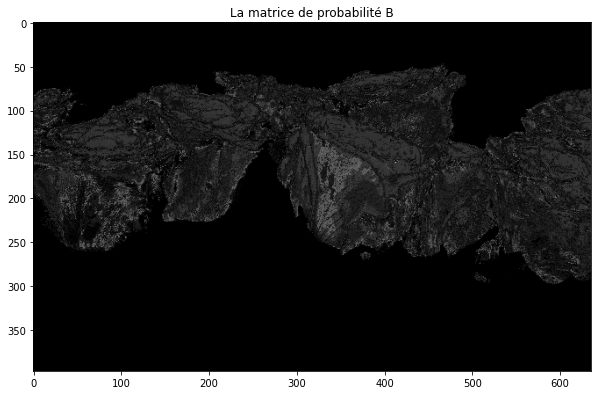

In [26]:
# A compléter
# Création et affichage de l'image B

# Version simple avec boucles
height,width,_ = hsv_image.shape
B = np.zeros((height,width),dtype=np.float)
for i in range(height):
    for j in range(width):
        B[i,j]=np.min(R[hsv_image[i,j,0],hsv_image[i,j,1]])


# Version optimisée
h,s,v = cv2.split(hsv_image)
B = R[h.ravel(),s.ravel()]
B = np.minimum(B,1)
B = B.reshape(hsv_image.shape[:2])

plt.subplots(1,1,figsize=(10,10))
plt.imshow(B)
plt.title("La matrice de probabilité B")
plt.show()

*_Checkpoint 2_* : A ce stade, il se peut que vous n'obtenez pas un résultat satisfaisant (à base d'erreurs d'exécution, ou autre, etc.). Lors de l'affichage de la matrice de probabilité, si les pixels rouges de l'image originale ne ressortent pas distinctement (voir fichier "Checkpoint_2.jpg' dans le dossier "Base_images/voie_de_secours/" pour pouvoir comparer), c'est qu'il y a sûrement une erreur. Si vous n'obtenez pas exactement le même résultat que ce que j'ai, je vous conseille de ne pas perdre de temps dessus.

Si en revanche le résultat n'est pas satisfaisant, vous avez la possibilité d'utiliser la fonction OpenCV calcBackProject, où il vous faudra votre image HSV à analyser, et M, l'histogramme de votre ROI en format HSV.

/!\ : Il est fort probable que vous n'ayez pas le même résultat que la version d'OpenCV. Ceci est normal car nous effectuons pas exactement les mêmes opérations que l'algo d'OpenCV. Cependant, l'algorithme d'OpenCV retourne une matrice en uint8, donc il faudra normaliser le résultat pour avoir des valeurs comprises entre 0 et 1.

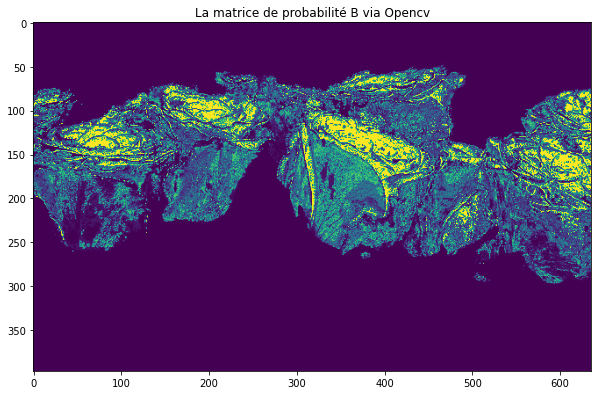

In [10]:
# A compléter
# Calcul et affichage de la backprojection de votre image à analyser avec la fonction OpenCV
B_cv2 = cv2.calcBackProject([hsv_image],[0,1],M,[0,180,0,256],1)
# Normalisation du résultat (float entre 0 et 1)
B_cv2 = B_cv2/255.

plt.subplots(1,1,figsize=(10,10))
plt.imshow(B_cv2)
plt.title("La matrice de probabilité B via Opencv")
plt.show()

---
6) Il est l'heure d'appliquer un filtrage sur B. Pour cela, créer un filtre elliptique de taille 5X5 (utilisé habituellement pour la morphologie mathématique), appliquez ce filtre via convolution sur B, normalisez le résultat en uint8 et affichez le résultat.

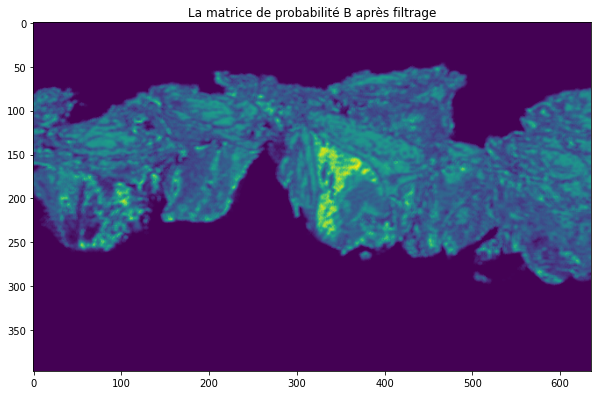

In [11]:
# A compléter
# Création du filtre elliptique, application de ce dernier sur B, normalisation et affichage du résultat 

# Création du filtre elliptique
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
# Application du filtre sur B
B = cv2.filter2D(B,-1,disc)
# Normalisation de l'image en uint8
B = np.uint8(B*255/B.max())
# Affichage du résultat
plt.subplots(1,1,figsize=(10,10))
plt.imshow(B)
plt.title("La matrice de probabilité B après filtrage")
plt.show()

---
7) Pour finir, appliquez une binarisation sur cette image pour obtenir un masque indiquant les pixels appartenant à la classe de votre ROI. Le seuil sera défini à la main. Affichez le résultat de cette binarisation.

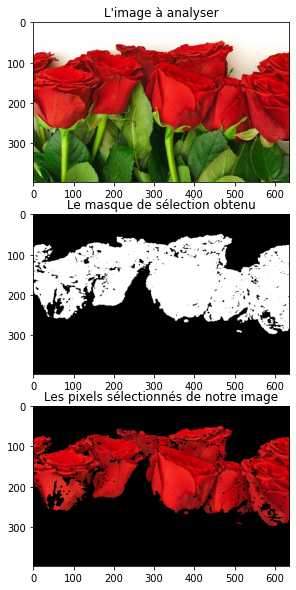

In [12]:
# A compléter
# Binarisation de B puis affichage du masque de sélection créé

# Binarisation de B
ret,thresh = cv2.threshold(B,50,255,0)

# Création d'une image montrant uniquement les pixels sélectionnés de l'image
output = cv2.cvtColor(thresh,cv2.COLOR_GRAY2RGB)
masque_selection = cv2.bitwise_and(image,output)

plt.subplots(3,1,figsize=(10,10))
plt.subplot(311)
plt.imshow(image)
plt.title("L'image à analyser")
plt.subplot(312)
plt.imshow(thresh,'gray')
plt.title("Le masque de sélection obtenu")
plt.subplot(313)
plt.imshow(masque_selection)
plt.title("Les pixels sélectionnés de notre image")
plt.show()

## Partie 2 : Cassiopée, apprentie influenceuse insta

Cassiopée a un seul objectif : percer sur Insta. Cependant, elle n'a pas encore assez de notorieté pour pouvoir avoir de nombreux partenariats et faire des placements de produits. Elle n'a donc pas assez d'argent pour pouvoir réaliser un shooting photo sur les plages de Dubaï et est donc coincée dans le Poitou-Charentes.

A partir de ce que vous avez implémenté précédemment, appliquez l'histogram backprojection sur la dernière photo de Cassiopée, allongée dans l'herbe (Cassiopee.jpg), et envoyez la à Dubaï avec un subtil montage photo grâce au fond disponible ("Dubai.jpg").

*_Indice :_* Cassiopée est difficile à segmenter... Il faudrait peut-être segmenter tout sauf Cassiopée...

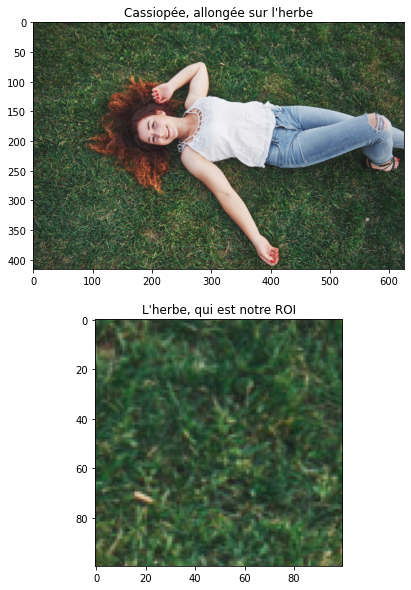

In [13]:
# Chargement de l'image
image = cv2.cvtColor(cv2.imread('../Base_images/Cassiopee.jpg',-1),cv2.COLOR_BGR2RGB)
# Définition de la ROI (l'herbe, que nous allons segmenter pour ensuite récupérer uniquement Cassiopée)
roi = image[0:100,300:400]
plt.subplots(2,1,figsize=(10,10))
plt.subplot(211)
plt.imshow(image)
plt.title("Cassiopée, allongée sur l'herbe")
plt.subplot(212)
plt.imshow(roi)
plt.title("L'herbe, qui est notre ROI")
plt.show()

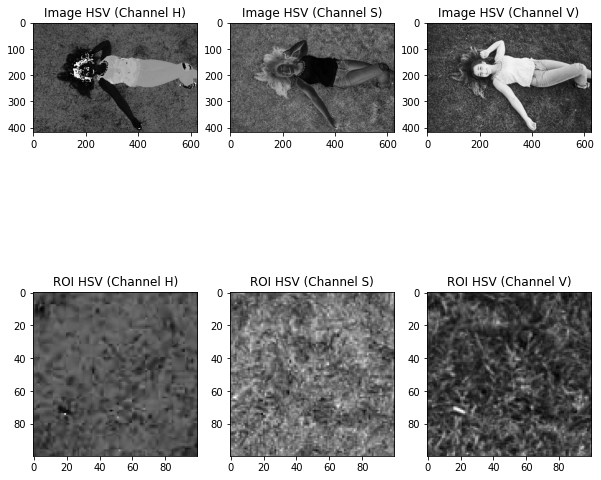

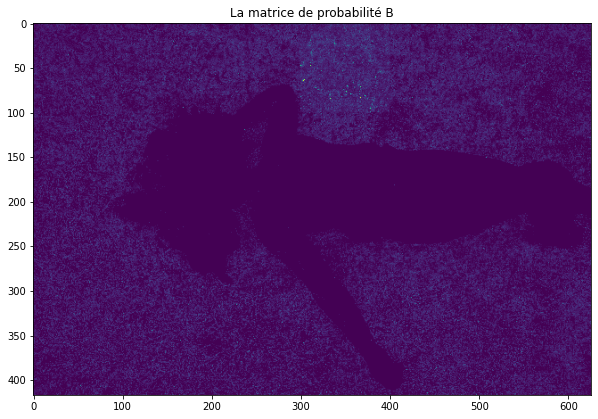

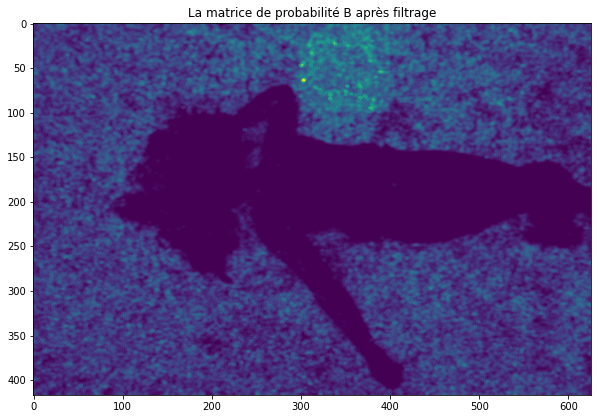

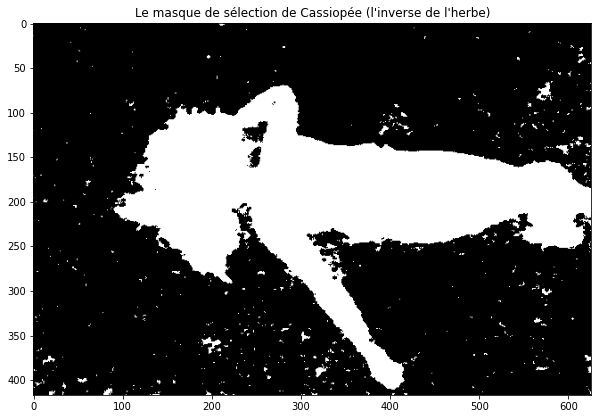

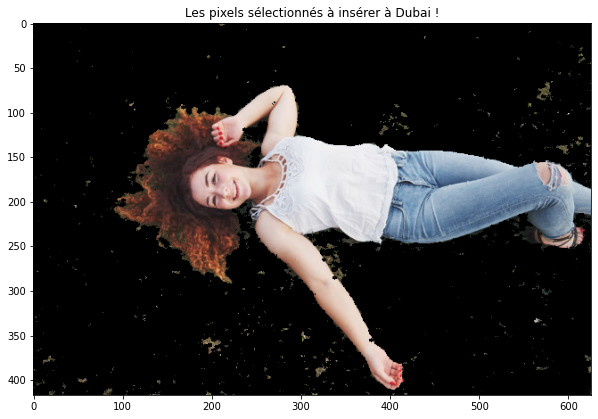

In [14]:
# Application de l'histogram back projection pour obtenir un masque avec l'herbe uniquement
hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
hsv_roi = cv2.cvtColor(roi,cv2.COLOR_RGB2HSV)
plt.subplots(2,3,figsize=(10,10))
plt.subplot(231)
plt.imshow(hsv_image[:,:,0],'gray')
plt.title("Image HSV (Channel H)")
plt.subplot(232)
plt.imshow(hsv_image[:,:,1],'gray')
plt.title("Image HSV (Channel S)")
plt.subplot(233)
plt.imshow(hsv_image[:,:,2],'gray')
plt.title("Image HSV (Channel V)")
plt.subplot(234)
plt.imshow(hsv_roi[:,:,0],'gray')
plt.title("ROI HSV (Channel H)")
plt.subplot(235)
plt.imshow(hsv_roi[:,:,1],'gray')
plt.title("ROI HSV (Channel S)")
plt.subplot(236)
plt.imshow(hsv_roi[:,:,2],'gray')
plt.title("ROI HSV (Channel V)")
plt.show()

I = cv2.calcHist([hsv_image],[0, 1], None, [180, 256], [0, 180, 0, 256])
M = cv2.calcHist([hsv_roi],[0, 1], None, [180, 256], [0, 180, 0, 256])
R = np.zeros((M.shape),dtype = np.float)
R[I>0] = M[I>0]/I[I>0]

h,s,v = cv2.split(hsv_image)
B = R[h.ravel(),s.ravel()]
B = np.minimum(B,1)
B = B.reshape(hsv_image.shape[:2])

plt.subplots(1,1,figsize=(10,10))
plt.imshow(B)
plt.title("La matrice de probabilité B")
plt.show()

disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
B = cv2.filter2D(B,-1,disc)
B = np.uint8(B*255/B.max())
plt.subplots(1,1,figsize=(10,10))
plt.imshow(B)
plt.title("La matrice de probabilité B après filtrage")
plt.show()

ret,thresh = cv2.threshold(B,9,255,cv2.THRESH_BINARY_INV)
plt.subplots(1,1,figsize=(10,10))
plt.imshow(thresh,'gray')
plt.title("Le masque de sélection de Cassiopée (l'inverse de l'herbe)")
plt.show()
output = cv2.cvtColor(thresh,cv2.COLOR_GRAY2RGB)
masque_selection = cv2.bitwise_and(image,output)
plt.subplots(1,1,figsize=(10,10))
plt.imshow(masque_selection)
plt.title("Les pixels sélectionnés à insérer à Dubai !")
plt.show()

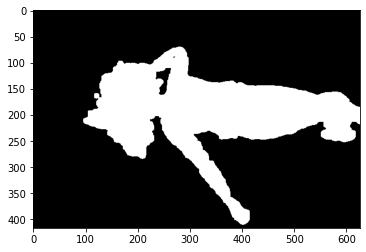

In [15]:
# On va tenter d'améliorer le masque avec un post-traitement
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
thresh_open = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel)
plt.imshow(thresh_open,'gray')


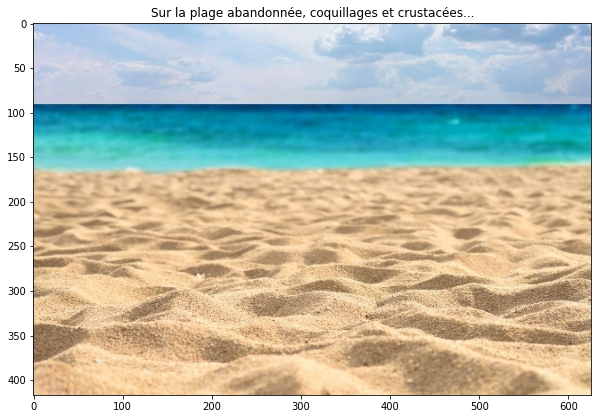

In [16]:
# Chargement du fond Dubai
background = cv2.cvtColor(cv2.imread(path_image+'Dubai.jpg',1),cv2.COLOR_BGR2RGB)
plt.subplots(1,1,figsize=(10,10))
plt.imshow(background)
plt.title("Sur la plage abandonnée, coquillages et crustacées...")
plt.show()

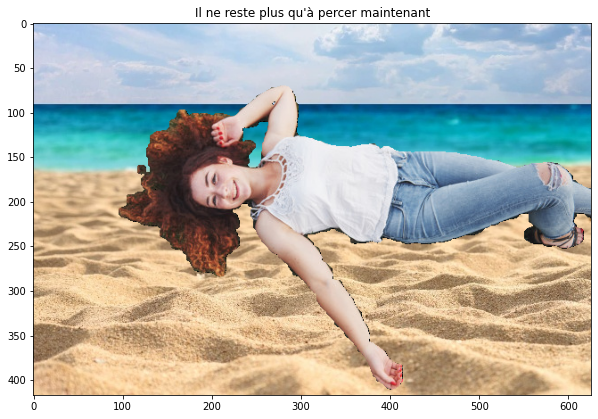

In [17]:
# Subtile insertion de Cassiopée sur le fond Dubai
background[thresh_open>0] = masque_selection[thresh_open>0]
plt.subplots(1,1,figsize=(10,10))
plt.imshow(background)
plt.title("Il ne reste plus qu'à percer maintenant")
plt.show()

Morale de l'histoire : Utilisez un fond vert

---
## Rendu
Le rendu qui vous est demandé est le notebook.  Vous le déposerez en fin d'examen sur Moodle, dans un dépot prévu à cet effet, dans le format NOM_Prenom_P1.ipynb 